# Libraries & importing dataset

In [304]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Problem of regression
df = pd.read_csv("Indicadores_municipales_sabana_DA.csv", index_col=0, sep=',', encoding='latin-1')
print("Total cells with nulls (previous):", df.isnull().sum().sum())
print("Dataset shape original:\n", df.shape)


Total cells with nulls (previous): 305
Dataset shape original:
 (2456, 138)


<!-- 1)Nombre del feature: N_pobreza_e	(Personas en pobreza extrema)

2)Tipo de problema: Regresion

3)Pregunta: No de personas en probreza extrema en x municipio -->


# Data Imputation

<!-- * Llenarlo con una constante (average) -->




In [305]:
#Data imputation
def fill_na_with_group_mean(group): #numeric
    return group.fillna(group.mean(numeric_only=True))

def fill_na_non_numeric_with_group_mean(group): #non-numeric
    for col in group.columns:
        if pd.api.types.is_numeric_dtype(group[col].dtype):
            group_mean = group[col].mean()
            group[col] = group[col].fillna(group_mean)
    return group


grouped = df.groupby('ent',group_keys=False)
df = grouped.apply(fill_na_with_group_mean)# For numerical


df = pd.get_dummies(df, columns=['gdo_rezsoc00','gdo_rezsoc05', 'gdo_rezsoc10']) # For non-numerical
grouped = df.groupby(['ent'],group_keys=False)
df = grouped.apply(fill_na_non_numeric_with_group_mean)

#Dropping columns that I dont need due to the problem I am solving
df = df.drop(columns=['clave_mun','nom_mun','nom_ent'])


print("Total cells with nulls (after):", df.isnull().sum().sum()) # #total cells with nulls after imputation
print("Dataset shape after imputation:\n", df.shape)


Total cells with nulls (after): 0
Dataset shape after imputation:
 (2456, 147)


# Analysis of correlation

pobreza              0.865271
pobreza_e            1.000000
vul_car             -0.830408
ic_rezedu            0.760958
ic_segsoc            0.714365
                       ...   
pobreza_cap_00       0.855403
pobreza_cap_10       0.923294
pobreza_patrim_90    0.787561
pobreza_patrim_00    0.805687
pobreza_patrim_10    0.870240
Length: 65, dtype: float64


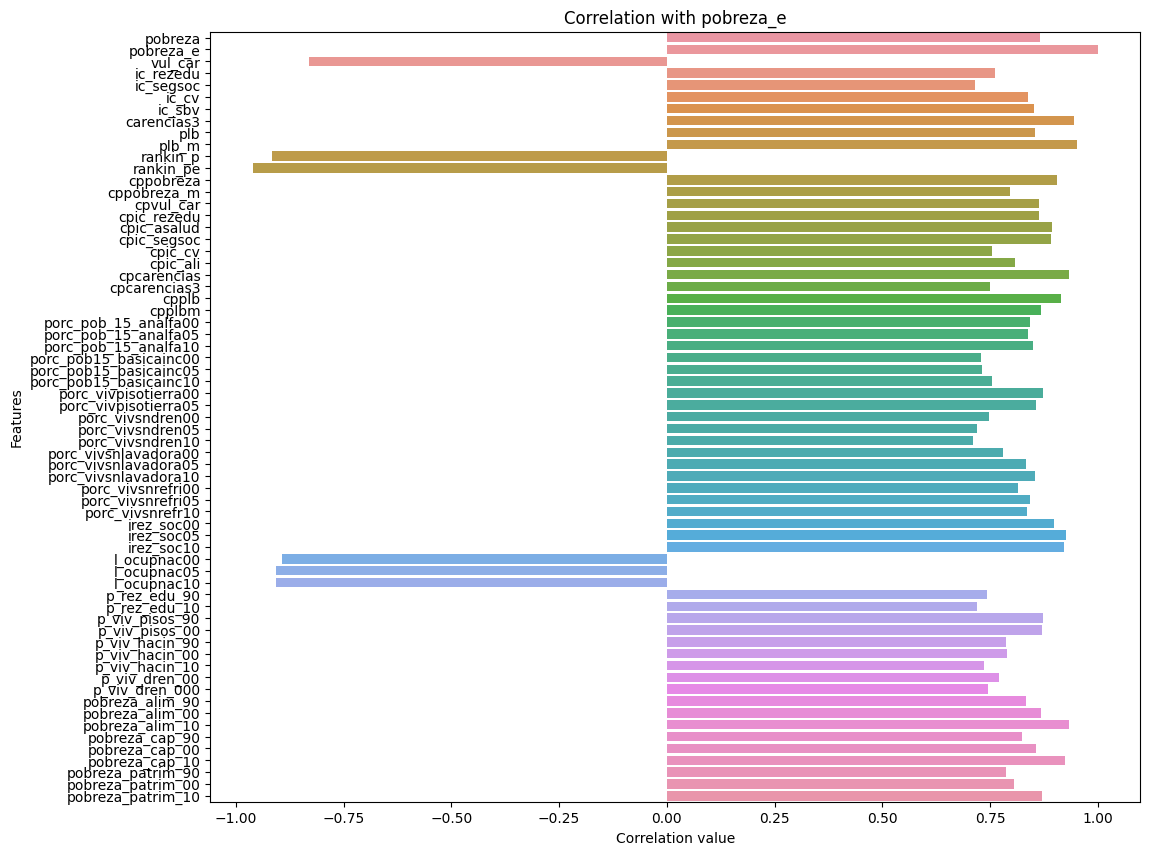

Features with high correlation Index(['pobreza', 'pobreza_e', 'vul_car', 'ic_rezedu', 'ic_segsoc', 'ic_cv',
       'ic_sbv', 'carencias3', 'plb', 'plb_m', 'rankin_p', 'rankin_pe',
       'cppobreza', 'cppobreza_m', 'cpvul_car', 'cpic_rezedu', 'cpic_asalud',
       'cpic_segsoc', 'cpic_cv', 'cpic_ali', 'cpcarencias', 'cpcarencias3',
       'cpplb', 'cpplbm', 'porc_pob_15_analfa00', 'porc_pob_15_analfa05',
       'porc_pob_15_analfa10', 'porc_pob15_basicainc00',
       'porc_pob15_basicainc05', 'porc_pob15_basicainc10',
       'porc_vivpisotierra00', 'porc_vivpisotierra05', 'porc_vivsndren00',
       'porc_vivsndren05', 'porc_vivsndren10', 'porc_vivsnlavadora00',
       'porc_vivsnlavadora05', 'porc_vivsnlavadora10', 'porc_vivsnrefri00',
       'porc_vivsnrefri05', 'porc_vivsnrefr10', 'irez_soc00', 'irez_soc05',
       'irez_soc10', 'l_ocupnac00', 'l_ocupnac05', 'l_ocupnac10',
       'p_rez_edu_90', 'p_rez_edu_10', 'p_viv_pisos_90', 'p_viv_pisos_00',
       'p_viv_hacin_90', 'p_viv_hacin

In [306]:
#Correlation Analysis
target = df['pobreza_e']
correlation = df.corrwith(target, numeric_only=True)
filt_corr = correlation[(correlation <= -0.7) | (correlation >= 0.7)]
features_corr_keep = filt_corr
print(features_corr_keep)

#Histogram comparing correlation between pobreza_e
plt.figure(figsize=(12,10))
sns.barplot(x=filt_corr.values, y=filt_corr.index)
plt.title('Correlation with pobreza_e')
plt.xlabel('Correlation value')
plt.ylabel('Features')
plt.show()

#Features and new dataset
print("Features with high correlation",features_corr_keep.keys())
df_filtered = df.drop(columns= features_corr_keep.index) #Only keeps the features that does not lie between the correlation range
df = df[features_corr_keep.keys()] #Only keeps the features with higgest correlation


Text(0.5, 1.0, 'Correlation between independent variables (filtered)')

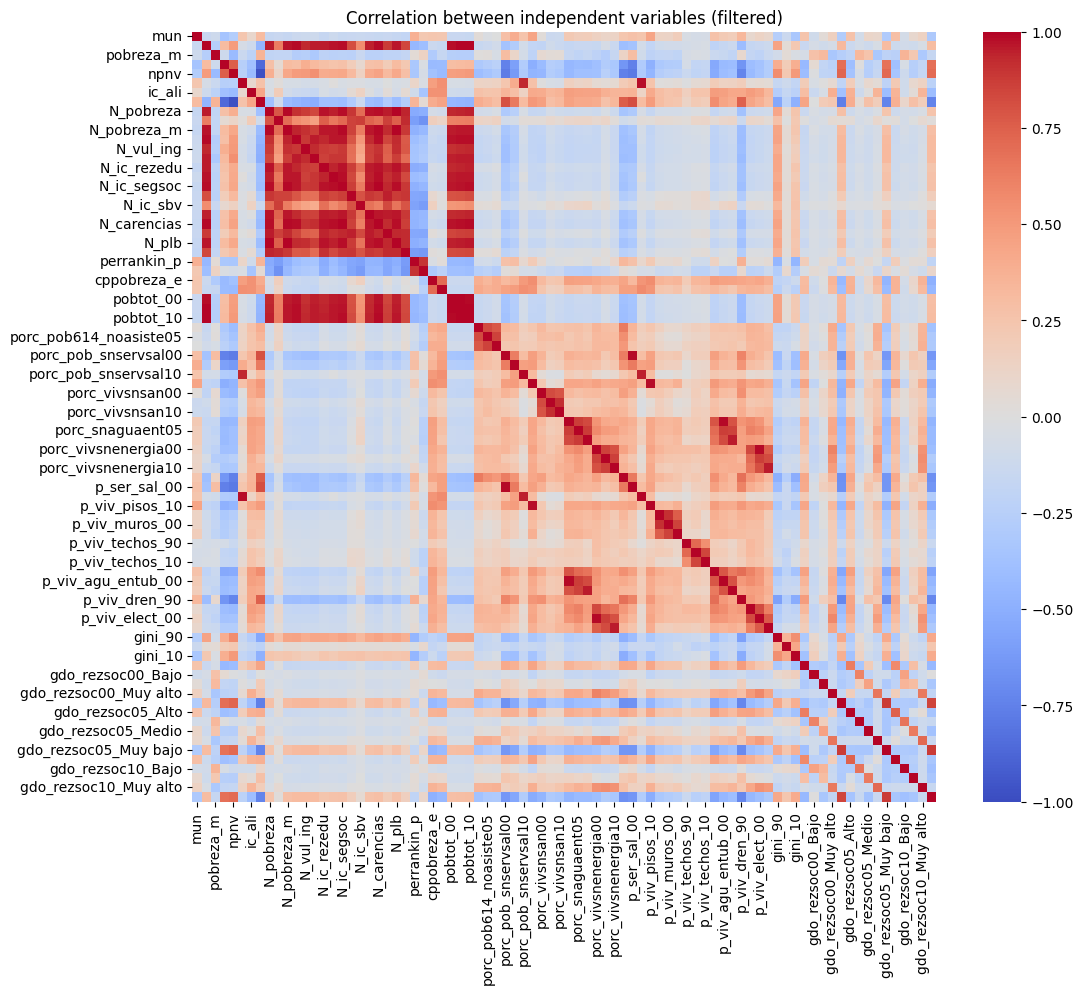

In [307]:
# Matrix of correlation
correlation_matrix = df_filtered.corr()
#Cold-warm map
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot= False,  cmap='coolwarm', vmin= -1, vmax= 1 )
plt.title('Correlation between independent variables (filtered)')


In [308]:
correlation_matrix

,mun,pobtot_ajustada,pobreza_m,vul_ing,npnv,ic_asalud,ic_ali,carencias,N_pobreza,N_pobreza_e,...,gdo_rezsoc05_Alto,gdo_rezsoc05_Bajo,gdo_rezsoc05_Medio,gdo_rezsoc05_Muy alto,gdo_rezsoc05_Muy bajo,gdo_rezsoc10_Alto,gdo_rezsoc10_Bajo,gdo_rezsoc10_Medio,gdo_rezsoc10_Muy alto,gdo_rezsoc10_Muy bajo
mun,1.000000,-0.142845,-0.116826,-0.353579,-0.275646,0.237736,0.088791,0.312302,-0.162267,-0.143764,...,0.264210,-0.085579,0.102877,0.088394,-0.295916,0.286262,-0.071671,0.079597,0.133843,-0.309726
pobtot_ajustada,-0.142845,1.000000,-0.263125,0.310153,0.486530,-0.056368,-0.114179,-0.461893,0.954161,0.629737,...,-0.125604,-0.071056,-0.110448,-0.048380,0.305270,-0.123207,-0.087848,-0.103269,-0.052734,0.298149
pobreza_m,-0.116826,-0.263125,1.000000,-0.112895,-0.424494,-0.139233,-0.218832,0.358118,-0.189858,-0.183055,...,-0.204011,0.329822,0.257476,-0.324555,-0.214538,-0.238861,0.353502,0.218800,-0.317081,-0.160678
vul_ing,-0.353579,0.310153,-0.112895,1.000000,0.753338,-0.253070,-0.388459,-0.863101,0.279935,0.059102,...,-0.395383,0.001677,-0.251822,-0.182051,0.674938,-0.384101,-0.054638,-0.254050,-0.186017,0.681777
npnv,-0.275646,0.486530,-0.424494,0.753338,1.000000,-0.249326,-0.421836,-0.982332,0.387837,0.115501,...,-0.366179,-0.066738,-0.263138,-0.162869,0.713887,-0.350754,-0.111880,-0.263626,-0.167538,0.704990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gdo_rezsoc10_Alto,0.286262,-0.123207,-0.238861,-0.384101,-0.350754,0.214737,0.355253,0.378667,-0.115625,0.025160,...,0.748034,-0.271263,-0.131520,0.023155,-0.316896,1.000000,-0.277782,-0.250825,-0.110336,-0.343714
gdo_rezsoc10_Bajo,-0.071671,-0.087848,0.353502,-0.054638,-0.111880,-0.098491,-0.099918,0.101467,-0.065708,-0.071696,...,-0.287697,0.671642,-0.010115,-0.117424,-0.299720,-0.277782,1.000000,-0.276023,-0.121421,-0.378244
gdo_rezsoc10_Medio,0.079597,-0.103269,0.218800,-0.254050,-0.263626,0.078324,0.037333,0.274748,-0.084312,-0.004820,...,-0.048893,-0.199186,0.637144,-0.106029,-0.312632,-0.250825,-0.276023,1.000000,-0.109638,-0.341538
gdo_rezsoc10_Muy alto,0.133843,-0.052734,-0.317081,-0.186017,-0.167538,0.134800,0.350897,0.181597,-0.044230,0.066724,...,0.040699,-0.119628,-0.118937,0.718437,-0.138518,-0.110336,-0.121421,-0.109638,1.000000,-0.150240


# Verification regression case

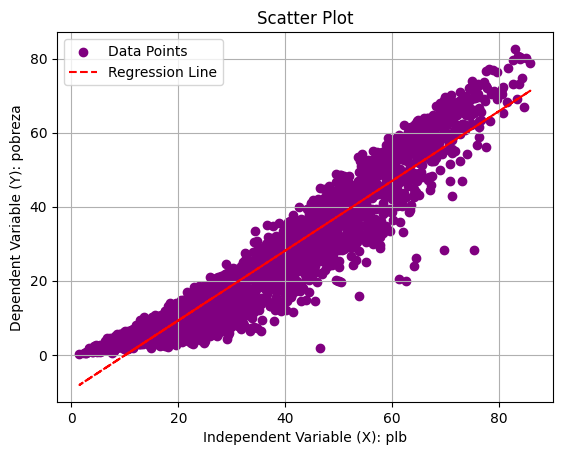

In [309]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


# Target and feature
target = 'pobreza_e'
features = 'plb_m'

# Independent variable (x) and Dependent variable (y)
X = df[features].values
Y = df[target].values


# Create a scatter plot
plt.scatter(X, Y, label='Data Points', color ='purple')
plt.xlabel('Independent Variable (X): plb')
plt.ylabel('Dependent Variable (Y): pobreza')
plt.title('Scatter Plot')
plt.legend()
plt.grid(True)

# Perform linear regression
model = LinearRegression()
model.fit(X.reshape(-1, 1), Y.reshape(-1, 1))

# Get the coefficients
slope = model.coef_[0]
intercept = model.intercept_

# Plot the regression line
plt.plot(X, model.predict(X.reshape(-1, 1)),linestyle = '--', color='red', label='Regression Line')
plt.legend()
plt.show()

# Regression algorithm (from scratch)

In [310]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Target and feature
target = 'pobreza_e'
features = ['vul_car', 'ic_rezedu', 'ic_segsoc', 'ic_cv',
       'ic_sbv', 'carencias3', 'plb', 'plb_m', 'rankin_p', 'rankin_pe',
       'cppobreza', 'cppobreza_m', 'cpvul_car', 'cpic_rezedu', 'cpic_asalud',
       'cpic_segsoc', 'cpic_cv', 'cpic_ali', 'cpcarencias', 'cpcarencias3',
       'cpplb', 'cpplbm', 'porc_pob_15_analfa00', 'porc_pob_15_analfa05',
       'porc_pob_15_analfa10', 'porc_pob15_basicainc00',
       'porc_pob15_basicainc05', 'porc_pob15_basicainc10',
       'porc_vivpisotierra00', 'porc_vivpisotierra05', 'porc_vivsndren00',
       'porc_vivsndren05', 'porc_vivsndren10', 'porc_vivsnlavadora00',
       'porc_vivsnlavadora05', 'porc_vivsnlavadora10', 'porc_vivsnrefri00',
       'porc_vivsnrefri05', 'porc_vivsnrefr10', 'irez_soc00', 'irez_soc05',
       'irez_soc10', 'l_ocupnac00', 'l_ocupnac05', 'l_ocupnac10',
       'p_rez_edu_90', 'p_rez_edu_10', 'p_viv_pisos_90', 'p_viv_pisos_00',
       'p_viv_hacin_90', 'p_viv_hacin_00', 'p_viv_hacin_10', 'p_viv_dren_00',
       'p_viv_dren_000', 'pobreza_alim_90', 'pobreza_alim_00',
       'pobreza_alim_10', 'pobreza_cap_90', 'pobreza_cap_00', 'pobreza_cap_10',
       'pobreza_patrim_90', 'pobreza_patrim_00', 'pobreza_patrim_10']

# Independent variable (x) and Dependent variable (y)
X = df[features]
y = df[target]

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)
#Standirized data
X_train_standardized = (X_train - X_train .mean()) / X_train.std()
X_test_standardized  = (X_test - X_train.mean()) /  X_train.std()

In [311]:
def error_function(y_actual,y_predicted):
    error = 0
    for i in range(0,len(y_actual)):
        error =  error + pow((y_actual[i] - y_predicted[i]),2)
        return error/(2*len(y_actual))

def y_predicted(w,x):
    y_pred = np.zeros(len(x))
    for i in range(0,len(x)):
        for j in range(0,len(w)):
            y_pred[i] = y_pred[i]+(w[j]*x[i][j] + w[-1])
    return y_pred

def gradient_descent(y_actual,y_pred,x):
    grad = np.zeros(x.shape[1])
    for i in range(x.shape[1]):
        for j in range(0,len(y_actual)):
            grad[i] = - (y_actual[j] - y_pred[j])*x[j][i] + grad[i]
    return grad/len(y_actual)


def weights(x_train,y_train,num_iterations,learning_rate):
    no_of_rows = x_train.shape[0]
    no_of_columns = x_train.shape[1]
    new_x_train = np.ones((no_of_rows,no_of_columns+1))
    new_x_train[:,0:no_of_columns] = x_train
    w = np.zeros(no_of_columns)
    w =np.append(w,1)
    for i in range(0,num_iterations):
        y_pred = y_predicted(w,new_x_train)
        error = error_function(y_train,y_pred)
        print("mean square error: ",error,"after",i,"th iteration")
        MSE_points.append(error)
        grad = gradient_descent(y_train,y_pred,new_x_train)
        w = w - learning_rate*grad
        learning_rate = learning_rate/1.05                                # Learning rate Decay
    return w

def regression_test(x_test,w):
    row = x_test.shape[0]
    column = x_test.shape[1]
    new_x_test = np.ones((row,column+1))
    new_x_test[:,0:column] = x_test
    y_pred = y_predicted(w,new_x_test)
    return(y_pred)

In [312]:
MSE_points = []
num_iterations = 300
learning_rate = 0.1
w = weights(X_train_standardized,Y_train,num_iterations,learning_rate)
Y_pred = regression_test(X_test_standardized,w)
error_function(Y_test,Y_pred)

mean square error:  0.6730760113047644 after 0 th iteration
mean square error:  15.773531140343113 after 1 th iteration
mean square error:  407.7403501954793 after 2 th iteration
mean square error:  9225.6596529225 after 3 th iteration
mean square error:  189410.85331087466 after 4 th iteration
mean square error:  3483545.2957937736 after 5 th iteration
mean square error:  57243618.97152581 after 6 th iteration
mean square error:  837167777.0883673 after 7 th iteration
mean square error:  10862791313.74404 after 8 th iteration
mean square error:  124700407301.22101 after 9 th iteration
mean square error:  1263098904904.835 after 10 th iteration
mean square error:  11259838080318.57 after 11 th iteration
mean square error:  88112971762010.78 after 12 th iteration
mean square error:  603703312827059.9 after 13 th iteration
mean square error:  3611580576100098.5 after 14 th iteration
mean square error:  1.881064925143635e+16 after 15 th iteration
mean square error:  8.503416540915891e+16 

0.03010395234703431

In [313]:
pred_df = pd.DataFrame(
    {
        'Actual Value' : Y_test,
     'Predicted Values' : Y_pred,
    }
)
pred_df.head(10)

,Actual Value,Predicted Values
0,34.793250,40.235886
1,13.009944,16.108588
2,10.605065,15.416072
3,47.951016,47.939606
4,58.783180,55.955829
5,6.014646,9.173305
6,28.804022,34.832182
7,9.510848,8.447453
8,54.895018,54.663313
9,28.197927,24.830530


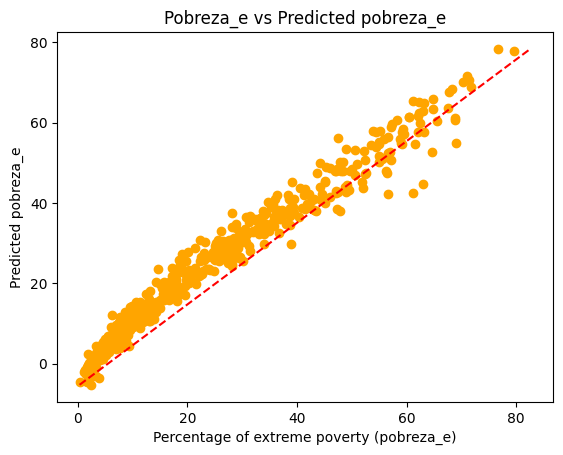

In [314]:
plt.scatter(Y_test, Y_pred, color='orange')
plt.plot([min(Y_train), max(Y_train)], [min(Y_pred), max(Y_pred)], linestyle='--', color='red', label='Línea de Regresión')


plt.xlabel("Percentage of extreme poverty (pobreza_e)")
plt.ylabel("Predicted pobreza_e")
plt.title("Pobreza_e vs Predicted pobreza_e")
plt.show()

In [315]:
from sklearn.metrics import mean_squared_error

MSE_custom_LR_Model = mean_squared_error(Y_test, Y_pred)
print("mean_squared_error: ", MSE_custom_LR_Model)


# Calcular el Coeficiente de Determinación (R^2) manualmente
y_mean = np.mean(Y_test)
sst = np.sum((Y_test - y_mean) ** 2)
ssr = np.sum((Y_test - Y_pred) ** 2)
r2 = 1 - (ssr / sst)

print('Coeficiente de determinación (R^2):', r2)

mean_squared_error:  12.542354846014982
Coeficiente de determinación (R^2): 0.9645829878349956


# Regression algorithm (sklearn)

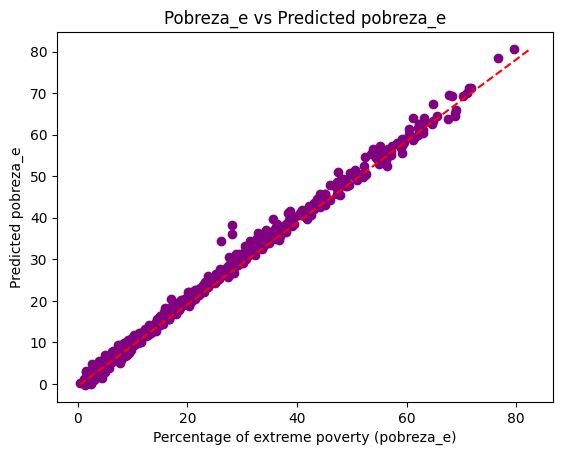

In [316]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

lm = LinearRegression()
lm.fit(X_train, Y_train)


y_pred_from_sklearn = lm.predict(X_test)

plt.scatter(Y_test, y_pred_from_sklearn, color='purple')
plt.plot([min(Y_train), max(Y_train)], [min(y_pred_from_sklearn), max(y_pred_from_sklearn)], linestyle='--', color='red', label='Línea de Regresión')

plt.xlabel("Percentage of extreme poverty (pobreza_e)")
plt.ylabel("Predicted pobreza_e")
plt.title("Pobreza_e vs Predicted pobreza_e")
plt.show()


In [317]:
sklearn_pred_df = pd.DataFrame(
    {
        'Actual Value' : Y_test,
     'Predicted Values' : y_pred_from_sklearn
    }
)
sklearn_pred_df.head(10)

,Actual Value,Predicted Values
0,34.793250,34.380663
1,13.009944,13.309818
2,10.605065,10.395164
3,47.951016,49.185143
4,58.783180,57.306751
5,6.014646,6.244139
6,28.804022,31.251381
7,9.510848,9.586851
8,54.895018,55.431094
9,28.197927,26.750633


In [318]:
from sklearn.metrics import mean_squared_error,r2_score

MSE_sklearn_LR_Model = mean_squared_error(Y_test, y_pred_from_sklearn)

print("mean_squared_error: ",MSE_sklearn_LR_Model)

r2_sklearn = r2_score(Y_test, y_pred_from_sklearn)
print('Coeficiente de determinación (R^2):', r2_sklearn)



mean_squared_error:  2.0118808902892984
Coeficiente de determinación (R^2): 0.9943188650902701


#Results comparison

In [319]:
from prettytable import PrettyTable

x = PrettyTable(['Models', 'MSE','Coeficiente de determinación (R^2)'])

x.add_row(['Linear Regression (SKLEARN)', MSE_sklearn_LR_Model, r2_sklearn])
x.add_row(['Linear Regression (From Scratch)', MSE_custom_LR_Model, r2])
print(x)

+----------------------------------+--------------------+------------------------------------+
|              Models              |        MSE         | Coeficiente de determinación (R^2) |
+----------------------------------+--------------------+------------------------------------+
|   Linear Regression (SKLEARN)    | 2.0118808902892984 |         0.9943188650902701         |
| Linear Regression (From Scratch) | 12.542354846014982 |         0.9645829878349956         |
+----------------------------------+--------------------+------------------------------------+
